 ## NBA Player Projections for Trade Analysis

**Harvard University**<br/>
**Fall 2023**<br/>

<hr style="height:2.4pt">

<a id="contents"></a>

## Table Of Contents: 

- [**Overview**](#intro)

- [**Description of Data**](#part1)

- [**EDA**](#part2)

- [**Modeling Approach**](#part3)

- [**Results/Discussion**](#part4)

- [**Conclusion**](#part5)


<a id="intro"></a>

## Overview

[Return to contents](#contents)

### Description of Project

Teams in the NBA frequently make transactions. From signings to trades, it is often difficult to evaluate how teams will perform after such a flurry of moves. We attempt to address this by using historical data to predict future player performance. In particular, we wonder, given a player’s statistics last year, how can we expect them to perform in the following year? By answering this question, we can begin to evaluate team transactions.

<a id="part1"></a>

## Description of Data

[Return to contents](#contents)

Our data is primarily sourced from basketball-reference.com. You can find these statistics under every season’s webpage. Our data contains every player season from 1995-2023. The data contained includes descriptions of their on-court production like rebounding percentage (rate at which a player grabs rebounds while on court), assist rate, turnover rate and so on. It also includes information about the player’s themselves, including their age and position. There are also advanced statistics that are included in the data, which are descriptive statistics developed by others that is intended to better quantify player performance like VORP and WS. These two in particular can be interpreted as an estimate for how many wins a player contributes to their team.

All of our features are rate statistics, so we divided offensive win shares (ows) and defensive win shares (dws) by minutes, as rate statistics are generally more predictive than total statistics. Furthermore, we realized that a feature involving scoring volume specifically was missing, so we created a new statistic that captured that information. Our final new feature was the one we are trying to predict- next_year_VORP. This is the VORP value for a season following a particular player’s season, as we are trying to predict how a player will play in the following season. VORP stands for Value Over Replacement Player. It measures a player’s value during a season. This can be translated to Wins Above Replacement (WAR), by multiplying by 2.7. WAR is an estimate for how many more wins a team would win with that player compared to a replacement player.

<a id="part2"></a>

## EDA

[Return to contents](#contents)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Correlation Matrix

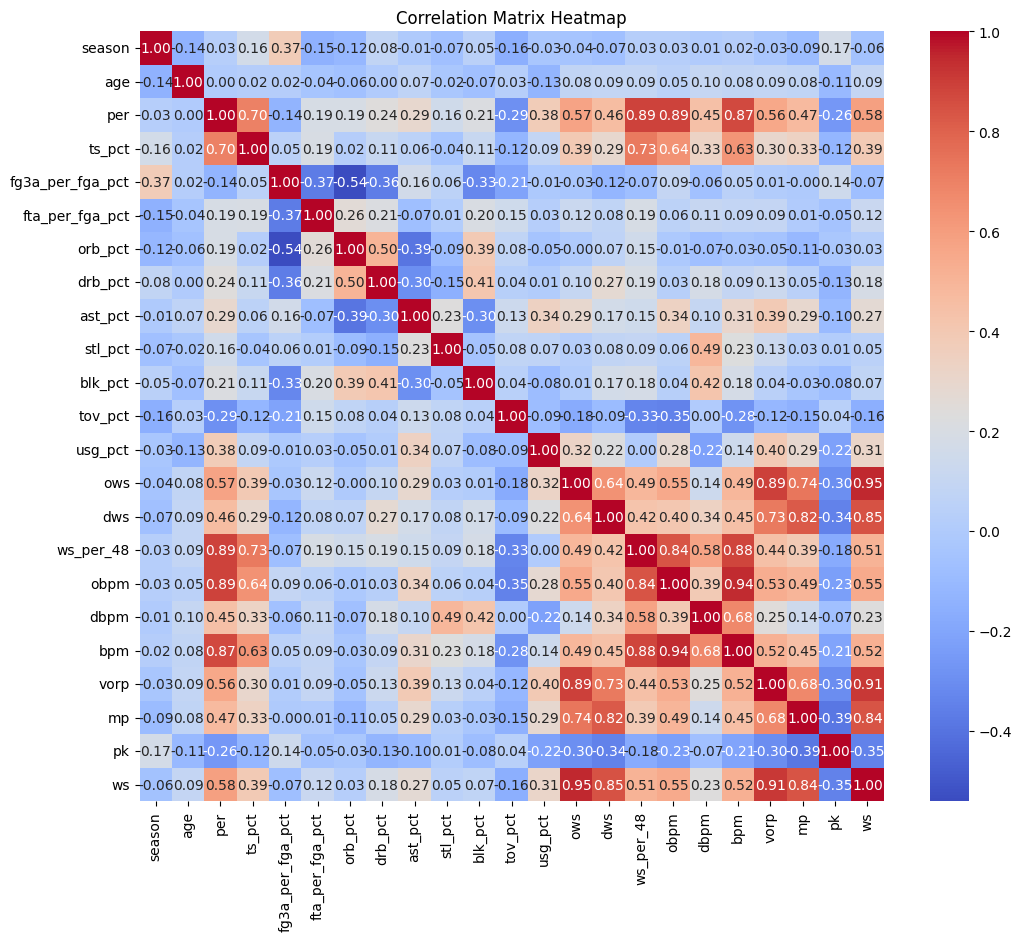

In [2]:
# Load the data
df = pd.read_csv('basketball.csv')

# Add win shares column
df['ws'] = df['ows'] + df['dws']

numeric_df = df.select_dtypes(include=[float, int])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

1. High Positive Correlations: There are several pairs of statistics that show a strong positive correlation (coefficients close to 1). For instance, Player Efficiency Rating (PER) is highly correlated with Win Shares per 48 minutes (WS/48), Offensive Box Plus/Minus (OBPM), and Box Plus/Minus (BPM). This suggests that these metrics are closely aligned in measuring a player's overall impact on the game. High values in one of these statistics are likely to be accompanied by high values in the others.
2. Negative Correlations: Some metrics show negative correlations, though they might be less pronounced. For instance, Usage Percentage (USG%) seems to have a negative correlation with Turnover Percentage (TOV%). This might indicate that players with higher ball possession and shot attempts (USG%) tend to have a lower ratio of turnovers, which could be characteristic of more skilled or efficient players.
3. Correlation with Age: The correlation of age with various stats is worth noting. While age does not show a strong correlation with most performance metrics, it can still provide insights into how a player's role or style of play evolves over time.
4. Three-Point Attempt Rate (3PA%): The 3PA% shows a significant positive correlation with the season year, indicating an increasing trend in three-point attempts over the years. This aligns with the general trend in modern basketball towards a greater emphasis on three-point shooting.
5. Minutes Played (MP): Minutes played shows positive correlations with both Offensive Win Shares (OWS) and Defensive Win Shares (DWS). This could indicate that players who contribute more to their team's success (either offensively or defensively) are likely to get more playing time.

We see that some of our predictors have high correlation. We consider this to be alright because a statistic like win shares (ws) is directly calculated by summing offensive win shares (ows) and defensive win shares (dws), thus naturally they will be highly correlated. 

### Distributions

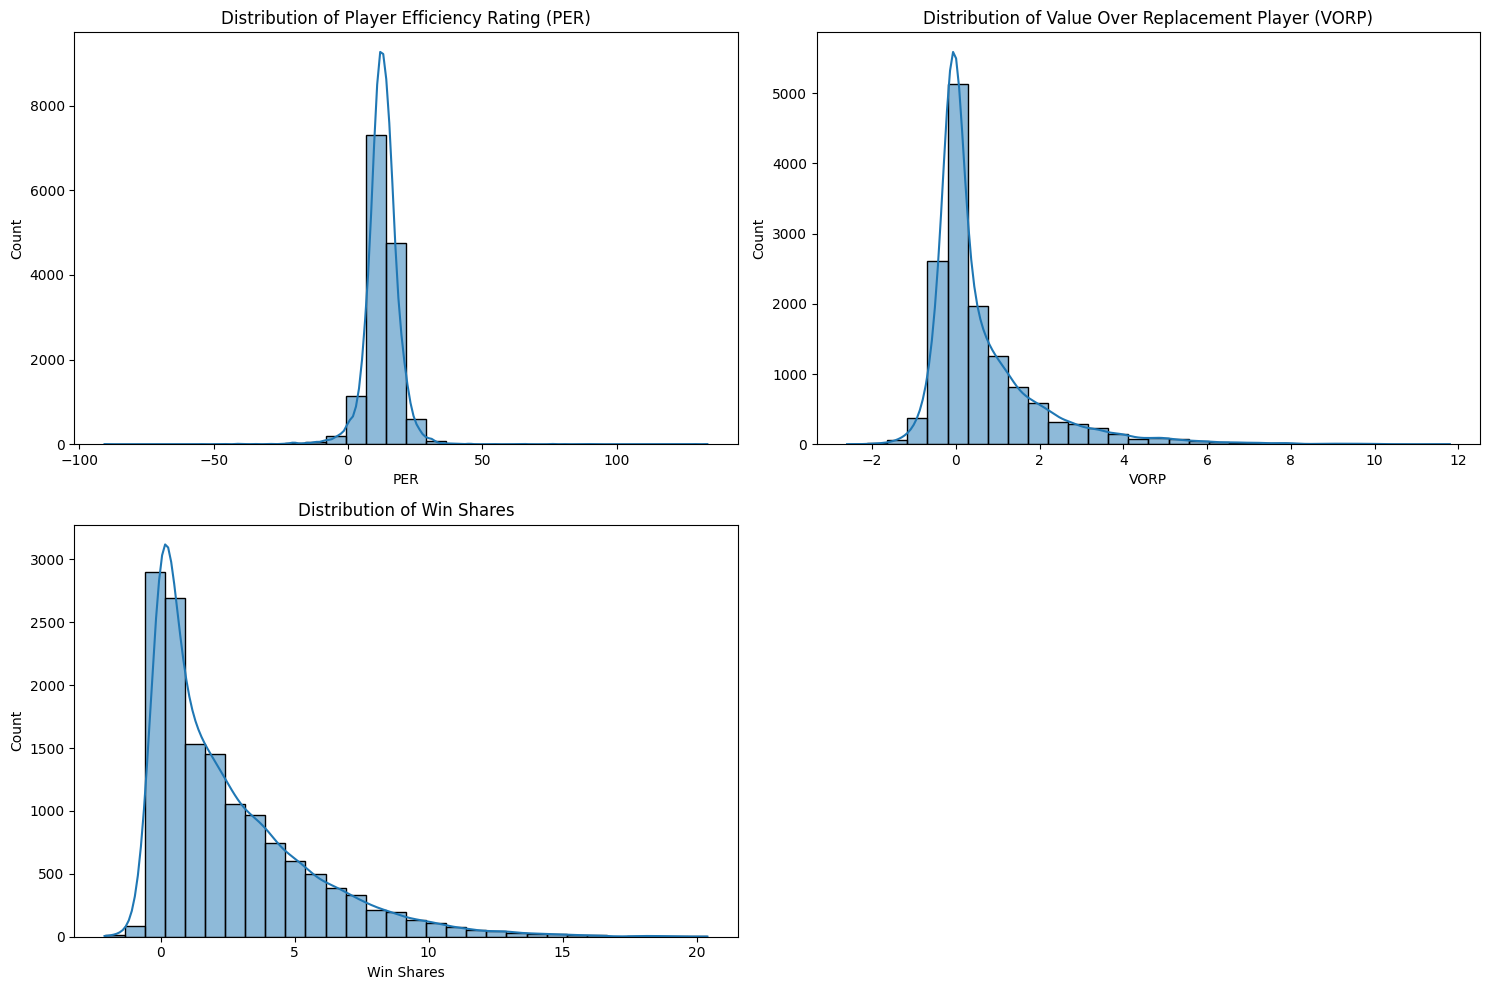

,season,age,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,ast_pct,stl_pct,...,ows,dws,ws_per_48,obpm,dbpm,bpm,vorp,mp,pk,ws
count,14196.000000,14196.000000,14193.000000,14181.000000,14180.000000,14180.000000,14193.000000,14193.000000,14193.000000,14193.000000,...,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14193.000000,14196.000000,13117.000000,14193.000000
mean,2010.169977,26.615526,12.785673,0.515590,0.251408,0.295151,5.703418,14.446802,13.007515,1.607418,...,1.311916,1.207928,0.073354,-1.501365,-0.173062,-1.674847,0.603968,1276.278600,30.814211,2.519844
std,8.658122,4.312319,6.356090,0.099924,0.220774,0.215345,4.841004,6.543513,9.406337,1.040265,...,2.008530,1.179002,0.102861,4.124270,1.869083,5.150797,1.315914,970.646654,21.614582,2.907453
min,1995.000000,18.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.300000,-1.000000,-2.519000,-68.900000,-31.100000,-92.100000,-2.600000,0.000000,1.000000,-2.100000
25%,2003.000000,23.000000,9.900000,0.483000,0.019000,0.177000,2.200000,9.800000,6.500000,1.100000,...,0.000000,0.300000,0.038000,-3.200000,-1.000000,-3.500000,-0.100000,386.000000,11.000000,0.300000
50%,2011.000000,26.000000,12.800000,0.527000,0.240000,0.262570,4.300000,13.400000,10.200000,1.500000,...,0.600000,0.900000,0.082000,-1.300000,-0.200000,-1.400000,0.100000,1151.500000,26.000000,1.600000
75%,2018.000000,30.000000,15.900000,0.565000,0.414000,0.369231,8.579279,18.400000,17.500000,2.000000,...,2.009390,1.800000,0.121000,0.400000,0.700000,0.585853,0.900000,2022.250000,57.000000,3.900000
max,2023.000000,44.000000,133.800000,1.500000,1.000000,6.000000,100.000000,100.000000,100.000000,25.000000,...,14.800000,9.100000,2.712000,199.400000,60.700000,242.200000,11.800000,4202.000000,61.000000,20.400000


In [3]:
# Summary Statistics
summary_stats = df.describe()

# Plotting the distribution of key statistics - PER and VORP
plt.figure(figsize=(15, 10))

# Distribution of Player Efficiency Rating (PER)
plt.subplot(2, 2, 1)
sns.histplot(df['per'], kde=True, bins=30)
plt.title('Distribution of Player Efficiency Rating (PER)')
plt.xlabel('PER')

# Distribution of Value Over Replacement Player (VORP)
plt.subplot(2, 2, 2)
sns.histplot(df['vorp'], kde=True, bins=30)
plt.title('Distribution of Value Over Replacement Player (VORP)')
plt.xlabel('VORP')

# Distribution of Win Shares (WS)
plt.subplot(2, 2, 3)
sns.histplot(df['ws'], kde=True, bins=30)
plt.title('Distribution of Win Shares')
plt.xlabel('Win Shares')

plt.tight_layout()
plt.show()

summary_stats

Player Efficiency Rating (PER): The distribution of PER appears roughly normal but with some skewness. This indicates a range of performance levels among players, with most clustering around the mean. 

Value Over Replacement Player (VORP): The distribution of VORP is skewed, with many players having lower VORP values and a few players with very high VORP. This skewness might indicate that only a small number of players have a significantly higher impact compared to a replacement player.

Win Share (WS): The distribution of Win Shares in your dataset is skewed, with most players having WS values clustered around 0 and 1. This skewness suggests that a large number of players contribute relatively modestly to their team's wins, as indicated by lower WS values. At the same time, there are a few standout players with significantly higher WS, reflecting their exceptional contribution to the team's success.

### Trends

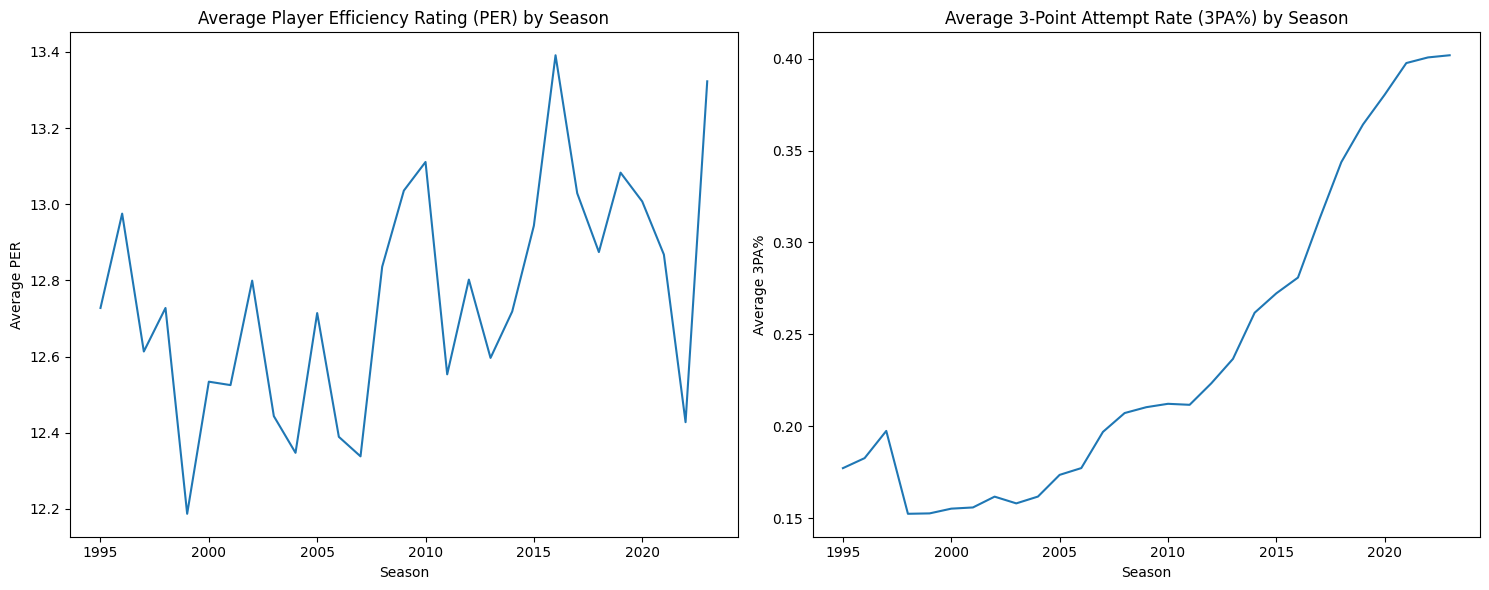

In [4]:
# Trends Over Time: Average PER and 3PA% by # Grouping by season and calculating the mean for PER and 3PA%
seasonal_trends = df.groupby('season')[['per', 'fg3a_per_fga_pct']].mean().reset_index()

# Plotting the trends
plt.figure(figsize=(15, 6))

# Average PER by Season
plt.subplot(1, 2, 1)
sns.lineplot(data=seasonal_trends, x='season', y='per')
plt.title('Average Player Efficiency Rating (PER) by Season')
plt.xlabel('Season')
plt.ylabel('Average PER')

# Average 3PA% by Season
plt.subplot(1, 2, 2)
sns.lineplot(data=seasonal_trends, x='season', y='fg3a_per_fga_pct')
plt.title('Average 3-Point Attempt Rate (3PA%) by Season')
plt.xlabel('Season')
plt.ylabel('Average 3PA%')

plt.tight_layout()
plt.show()

Average PER by Season: This line plot shows how the average PER has fluctuated over the years. Any trends or significant changes over time can indicate shifts in overall player efficiency in the league. 

Average 3PA% by Season: The increasing trend in the 3-Point Attempt Rate reflects the strategic shift in basketball towards more three-point shooting. This is consistent with the changes observed in modern basketball tactics. As time goes on, this may become an important predictor. 

### Positional Analysis

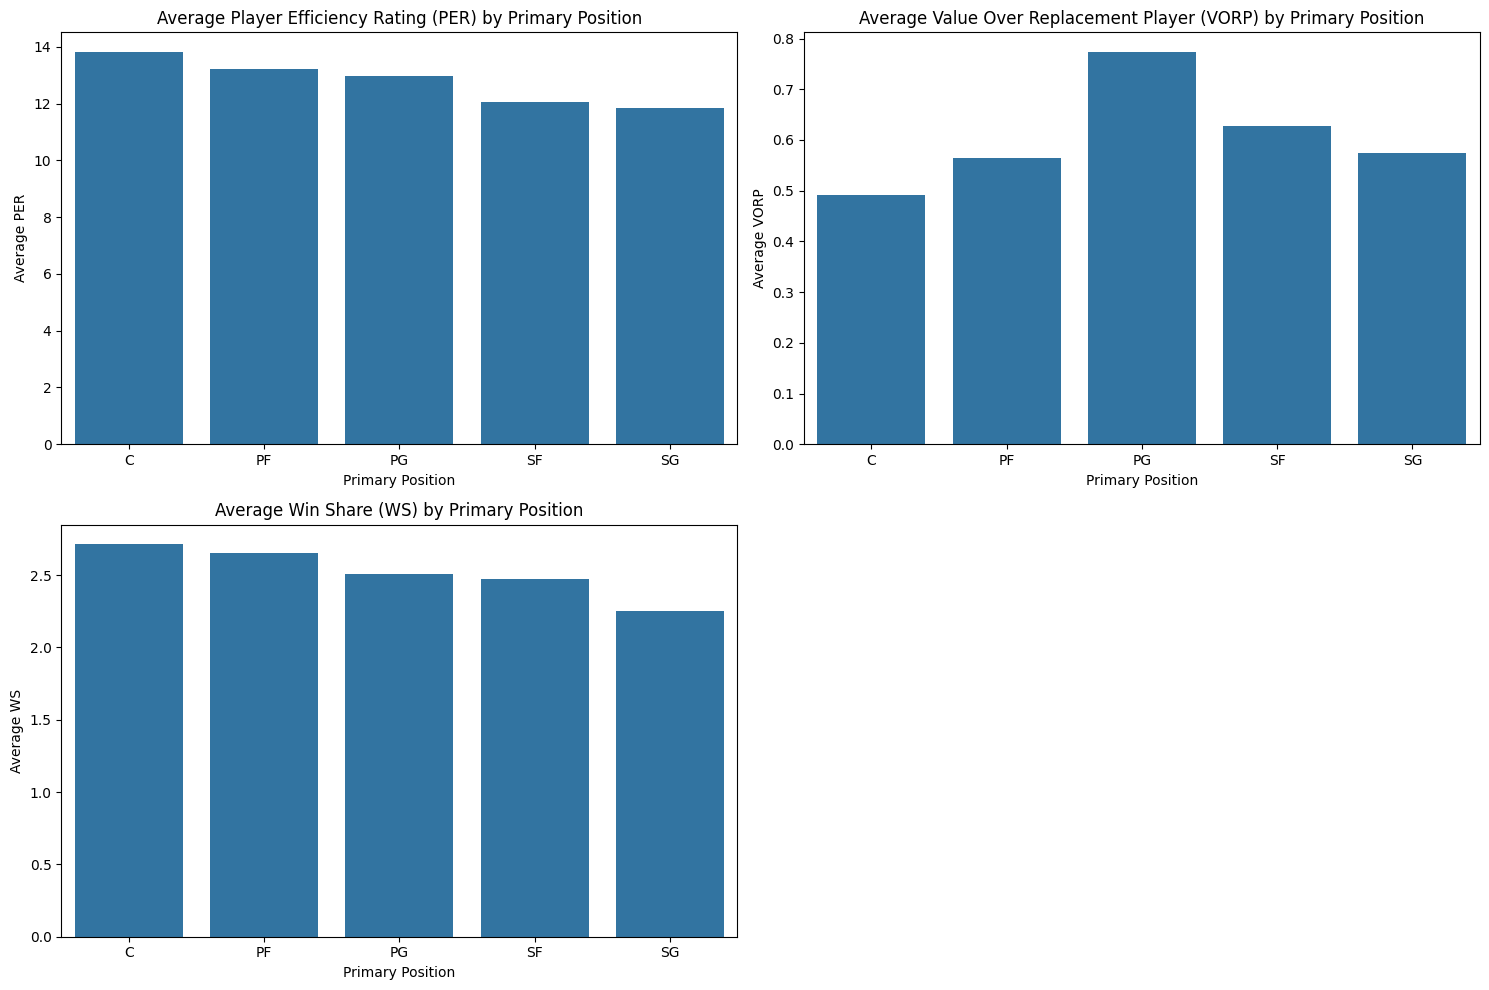

In [5]:
# Adjusting position grouping for multi-position players. 
# For multi-position players, the analysis will consider the first mentioned position.

# Splitting the position and keeping only the first one for multi-position players
df['primary_pos'] = df['pos'].apply(lambda x: x.split('-')[0])

# Recalculating the average PER and VORP by primary position
position_comparison = df.groupby('primary_pos')[['per', 'vorp', 'ws']].mean().reset_index()

# Plotting the comparisons by primary position
plt.figure(figsize=(15, 10))

# Average PER by Primary Position
plt.subplot(2, 2, 1)
sns.barplot(data=position_comparison, x='primary_pos', y='per')
plt.title('Average Player Efficiency Rating (PER) by Primary Position')
plt.xlabel('Primary Position')
plt.ylabel('Average PER')

# Average VORP by Primary Position
plt.subplot(2, 2, 2)
sns.barplot(data=position_comparison, x='primary_pos', y='vorp')
plt.title('Average Value Over Replacement Player (VORP) by Primary Position')
plt.xlabel('Primary Position')
plt.ylabel('Average VORP')

# Average WS by Primary Position
plt.subplot(2, 2, 3)
sns.barplot(data=position_comparison, x='primary_pos', y='ws')
plt.title('Average Win Share (WS) by Primary Position')
plt.xlabel('Primary Position')
plt.ylabel('Average WS')

plt.tight_layout()
plt.show()

Average Player Efficiency Rating (PER) by Primary Position: The PER, a measure of a player's per-minute productivity, varies across positions. The plot suggests that certain positions may have inherently higher PERs due to the nature of their roles in the game. For example, Centers (C) and Power Forwards (PF) have higher PERs due to their roles in rebounding, shot-blocking, and efficient close-range scoring. On the other hand, Guards (PG and SG) have lower PERs, which could be due to factors like shooting from longer distances (lower field goal percentage) or having different responsibilities on the court. 

Average Value Over Replacement Player (VORP) by Primary Position: VORP measures a player's contribution compared to a replacement-level player at the same position. The variation in VORP across positions can highlight which positions are more impactful in the context of the league. Point Guards (PG) have a noticeably higher average VORP, this might suggest that good players in these positions are particularly valuable and harder to replace. This could be due to the specialized skills required for these positions, such as playmaking and leadership for point guards or interior defense and rebounding for centers.

Average Win Share (WS) by Primary Position: Average Win Shares (WS) by Primary Position: Win Shares, as a metric that quantifies a player's contribution to team wins, can also vary significantly across different positions. The relative win shares mirror the average PER distribution show

<a id="part3"></a>

## Modeling Approach

[Return to contents](#contents)

![Model Pipeline](model_pipeline.drawio.png)

Our first step was implementing some feature engineering. All of our features are rate statistics, so I divided offensive win shares (ows) and defensive win shares (dws) by minutes, as rate statistics are generally more predictive than total statistics. Furthermore, we realized that a feature involving scoring volume specifically was missing, so we created a new statistic that captured that information. Our final new feature was the one we are trying to predict- next_year_VORP. This is the VORP value for a season following a particular player’s season, as we are trying to predict how a player will play in the following season. VORP stands for Value Over Replacement Player. It measures a player’s value during a season. This can be translated to Wins Above Replacement (WAR), by multiplying by 2.7. WAR is an estimate for how many more wins a team would win with that player compared to a replacement player.

We also had position as a categorical variable. We transformed it into numerical variables using one-hot encoding.

We have two baseline models. The first is simply taking the mean of all VORP values. The second is simply using a player’s previous season’s VORP value as the estimate for their following season’s VORP value.

The first model we implemented was a simple linear regression. This outperformed our baseline model by a reasonable amount. However, we noticed from EDA that there seemed to be some multicollinearity, so we followed up with Lasso regression with cross-validation on alpha. This, however, only marginally improved model performance.

We believed that there were many interaction terms between our features that would be difficult to capture in a linear regression. As a result, we turned to non-parametric methods. The second model we implemented was kNN. Of course, we first standardized our dataset. We then performed cross validation on the number of neighbors to use. After optimizing the number of neighbors, we found that kNN performed slightly worse than linear regression. 

The third model we implemented was a random forest. We used OOB scores to optimize depth of trees used. We found that the random forest performed the best yet out of our models. We were curious as to what features the model found the most important. We thought that this might be where random forest had an advantage over kNN, which is not able to take into account feature importance. This led to our next model.

Our fourth model was a kNN model on a transformed data set informed by random forest feature importance. We included a constant term to our scaling to control the impact the scaling had. We used cross-validation to optimize this constant. This modified kNN model outperformed our original kNN model. However, it did not outperform the original random forest model.

Next, we decided to improve upon our random forest model through feature selection. We used forward feature selection, by iteratively adding the features that the original random forest model considered to be the most important. We used cross-validation to optimize the number of features included. This provided marginal improvements.

Finally, we attempted Adaboost. At first, we used decision trees of depth 1, however, these did not converge to a performance that was better than the baseline model. We then attempted to use more complex trees by using the default value of depth 3. We then used cross validation to optimize the number of iterations.



<a id="part4"></a>

## Results/Discussion

[Return to contents](#contents)

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from scipy.optimize import curve_fit

## Draft Picks

In [ ]:
players_df = pd.read_csv('basketball.csv')

average_vorp_by_pick = players_df.groupby('pk')['vorp'].mean()

grouped_data = average_vorp_by_pick.reset_index()
x_data = grouped_data['pk']
y_data = grouped_data['vorp']

def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

params, _ = curve_fit(exp_decay, x_data, y_data, maxfev=5000)

plt.figure(figsize=(25, 10))
average_vorp_by_pick.plot(kind='bar', color='skyblue', label='Average Vorp per Pick')
plt.plot(x_data, exp_decay(x_data, *params), color='red', linestyle='--', linewidth=2, label='Exponential Decay Fit')
plt.title('Average Vorp by Draft Pick Position\n', size=25)
plt.xlabel('\nDraft Pick Position', size=20)
plt.ylabel('Average Vorp Total\n', size=20)
plt.xticks(range(0, 60), range(1, 61))  
plt.grid(axis='y')
plt.legend(fontsize=18)
plt.show()

As expected, we see from the graph that higher draft pick is a good indication of how good a player is. We do notice some fluctuation, and one outlier in particular, pick 57. This is likely due to one player (Many Ginobili), who played in the NBA for a very long time and was extremely successful. Many of the picks in the later rounds do not see many minutes, if any at all, so when one player good player is able to account for so much of the data for that specific pick, it makes sense that the projection is that much higher. Otherwise, the rest of the graph makes sense. Of course there is some fluctuation, like pick 10 being much better than picks 7, 8, and 9. However, these represent the inherent difficulty in picking the players correctly in the draft.  

## Player Projection Modeling

In [40]:
df = pd.read_csv('final_data.csv')
df['ws'] = df['ows'] + df['dws']
df['ows_per_48'] = 48 * df['ows'] / df['mp']
df['dws_per_48'] = 48 * df['dws'] / df['mp']
df['score_pct'] = (1 - df['tov_pct']) * (df['usg_pct'] * df['ts_pct'])
def encoder(s):
    if '-' not in s:
        return s
    return s.split('-')[0]

df['pos'] = df['pos'].apply(encoder)
encoded = OneHotEncoder(sparse=False)
onehot_encoded = encoded.fit_transform(df[['pos']])
encoded_df = pd.DataFrame(onehot_encoded, columns=encoded.get_feature_names_out(['pos']))

encoded_data = pd.concat([df, encoded_df], axis=1)
# Creating the 'next_year_vorp' variable

# Sort the data first by player_name and then by season to ensure correct sequential order
sorted_df = encoded_data.sort_values(by=['player_name', 'season'])

# Using groupby and shift to create the 'next_year_vorp' variable
sorted_df['next_year_vorp'] = sorted_df.groupby('player_name')['vorp'].shift(-1)
sorted_df = sorted_df.drop('pos', axis=1)
# Showing the first few rows of the dataset with the new variable
sorted_df.head()

C:\Users\steve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,player_name,season,age,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,ast_pct,...,ws,ows_per_48,dws_per_48,score_pct,pos_C,pos_PF,pos_PG,pos_SF,pos_SG,next_year_vorp
13654,A.C. Green,1995,31,14.200000,0.596000,0.206000,0.556000,8.300000,20.400000,6.500000,...,6.700000,0.072275,0.032995,-100.712080,0.0,0.0,0.0,1.0,0.0,0.400000
13248,A.C. Green,1996,32,12.900000,0.558000,0.117000,0.534000,9.200000,20.900000,4.900000,...,4.400000,0.058909,0.037091,-85.440960,0.0,0.0,0.0,1.0,0.0,0.356019
12820,A.C. Green,1997,33,12.390048,0.523461,0.041751,0.408162,10.210193,20.491894,4.382986,...,4.048154,0.040278,0.037696,-64.802404,0.0,1.0,0.0,0.0,0.0,0.400000
12379,A.C. Green,1998,34,12.800000,0.496000,0.007000,0.303000,9.000000,19.300000,7.300000,...,5.200000,0.050736,0.043488,-52.357760,0.0,1.0,0.0,0.0,0.0,0.000000
11940,A.C. Green,1999,35,12.500000,0.441000,0.031000,0.203000,9.900000,17.800000,4.500000,...,1.400000,0.036364,0.036364,-35.244720,0.0,1.0,0.0,0.0,0.0,0.800000


In [41]:
print(sorted_df.columns)

Index(['player_name', 'season', 'age', 'per', 'ts_pct', 'fg3a_per_fga_pct',
       'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'ast_pct', 'stl_pct',
       'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws_per_48', 'obpm',
       'dbpm', 'bpm', 'vorp', 'mp', 'ws', 'ows_per_48', 'dws_per_48',
       'score_pct', 'pos_C', 'pos_PF', 'pos_PG', 'pos_SF', 'pos_SG',
       'next_year_vorp'],
      dtype='object')


Note that here we have done some feature engineering, adding both win shares (ws) and scoring percentage (score_pct). We feel that these are necessary predictors that were left out of our dataset, but easy enough to calculate using the available information. 

In [54]:
# Dropping rows with missing values in 'next_year_vorp' as they cannot be used for prediction
# This typically includes the last season of each player
cleaned_df = sorted_df.dropna()

# Defining features (X) and target (y)
X = cleaned_df.drop('next_year_vorp', axis=1)
y = cleaned_df['next_year_vorp']

X_split = X.drop(['player_name', 'season'], axis=1)

# Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(X_split, y, test_size=0.2, random_state=0)

In [55]:
# Baseline Models
mse_naive_vorp = mean_squared_error(y_test, X_test['vorp'])
print(mse_naive_vorp) # keep it as 'baseline', this is basically we say the performance did not change from last year

mse_mean_vorp = np.std(X_test['vorp'])
print(mse_mean_vorp)

0.9443002237021798
1.3937720001994305


In [56]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
print(mse_lr)

0.7952451504461084


In [57]:
# Lasso Regression Model
lr = LinearRegression()
alphas = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

lasso = LassoCV(alphas = alphas, max_iter=50000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_pred, y_test)
print(mse_lasso)

0.7941494881154297


In [58]:
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Cross-validation scores for different numbers of neighbors
cv_scores = []
for k in range(1, 51):  # testing 1 to 50 neighbors
    knn = KNeighborsRegressor(n_neighbors = k)
    scores = cross_validate(knn, X_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores['test_score']))

print(cv_scores) # best is around 25

[1.2973611798108131, 0.9984095580930585, 0.8877909561874455, 0.8526797525923847, 0.8240864866445818, 0.8037348808457858, 0.794322682397661, 0.7801281068498199, 0.7756598385944081, 0.7682971484688308, 0.7627384109563795, 0.7616564400592358, 0.7561849912628714, 0.7544985436937802, 0.7532946693958822, 0.750000568425059, 0.7495849554485694, 0.7497039754638617, 0.7488771239763625, 0.7474486190449536, 0.7457463155023072, 0.7457547818779201, 0.7463708654873508, 0.7453821882496476, 0.7447508882387044, 0.7432216400127694, 0.7439011127471312, 0.7450070292005307, 0.7443813116757547, 0.745424384912302, 0.7458867864358011, 0.7466652299629256, 0.7467941473851007, 0.7469246396442457, 0.7473476851281615, 0.7459998246166547, 0.7466821478936589, 0.747262390392568, 0.7476227443336214, 0.7493453852858329, 0.7496232587732474, 0.749847180464345, 0.7500322004954901, 0.7496259833674086, 0.750215004804005, 0.7493309339724228, 0.7509742280157846, 0.752056450208989, 0.7532938939474361, 0.7544628399520537]


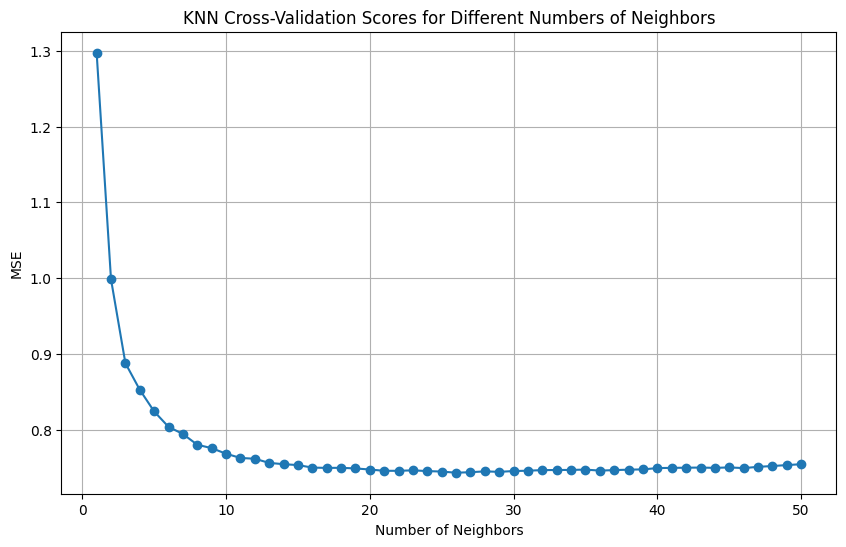

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), cv_scores, marker='o')
plt.title('KNN Cross-Validation Scores for Different Numbers of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

We see that we reach our lowest mse value between 20 and 30. We also note that these values seem to be extremely similar, with only marginal differences. For our testing, we will use 25 as our number of neighbors as it seems like a reasonable number to pick based on the graph and the local minima being reached between 20 and 30 neighbors. 

In [59]:
# KNN Regression Model
knn = KNeighborsRegressor(n_neighbors = 25)
X_test_scaled = scaler.transform(X_test)
knn.fit(X_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
mse_knn = mean_squared_error(y_pred, y_test)
print(mse_knn)

0.8287524042504205


In [60]:
# Random Forest Model
oob_r2_scores = []

for depth in range(1, 10):
    # Train the model
    forest = RandomForestRegressor(max_depth=depth, oob_score=True)
    forest.fit(X_train, y_train)
    # Calculate OOB MSE
    oob_r2_scores.append(forest.oob_score_)

print(oob_r2_scores)
# take 8 as the best depth

[0.4525228595593014, 0.5902771128752975, 0.6151364412142444, 0.6242828804245057, 0.6340675502903468, 0.6354469617090883, 0.6411154633735846, 0.6363854118349104, 0.636618786253833]


In [61]:
# Random Forest Model with depth = 8
forest = RandomForestRegressor(max_depth=8)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
mse_random_forest = mean_squared_error(y_pred, y_test)
print(mse_random_forest)

0.7736432210088056


In [18]:
# Extracting feature importances
feature_importances = forest.feature_importances_

# Creating a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

features_df

,Feature,Importance
18,vorp,0.732766
17,bpm,0.074434
0,age,0.024680
11,usg_pct,0.014988
20,ws,0.014133
19,mp,0.011607
1,per,0.010779
4,fta_per_fga_pct,0.009981
23,score_pct,0.009330
2,ts_pct,0.008782


Vorp is the best predictor of vorp, from the table. This makes perfect sense as vorp seems to be a very stable statistic over time. Thus, players that are considered good based on vorp, are expected to stay good as a result. We do find that other features exert some influence, and through this we look to improve our models using the feature weighting. 

In [62]:
# KNN neighbors using random forest feature importance weighting
knn_feat_mse = []
c_vals = [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1.0, 3.0, 5.0]
for c in c_vals: # best is 0.5
    X_feat_scaled = X_scaled * (feature_importances + c)
    knn = KNeighborsRegressor(n_neighbors=25)
    avg_mse = np.mean(cross_validate(knn, X_feat_scaled, y_train, cv=5, scoring='neg_mean_squared_error')['test_score'])
    knn_feat_mse.append(-avg_mse)

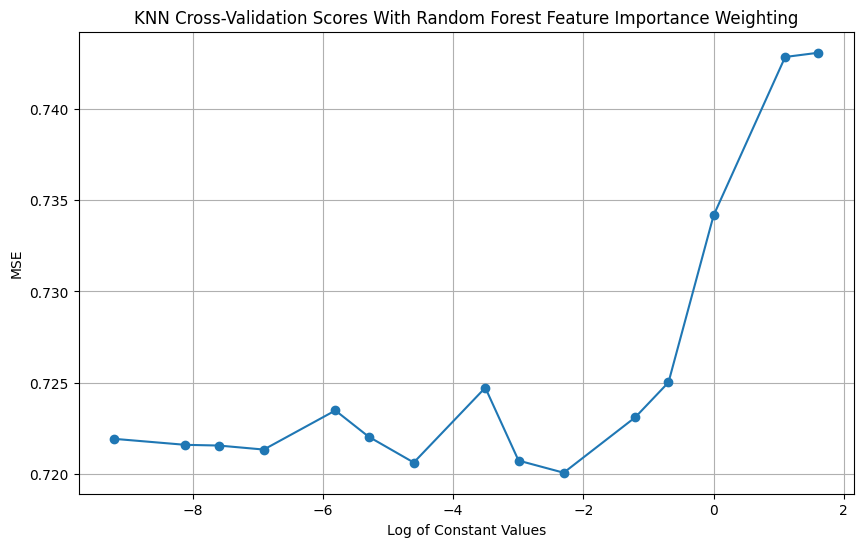

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(np.log(c_vals), knn_feat_mse, marker='o')
plt.title('KNN Cross-Validation Scores With Random Forest Feature Importance Weighting')
plt.xlabel('Log of Constant Values')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

From the graph we see that the best constant value is o.5 as it provides the lowest mse value. 

In [63]:
X_feat_scaled = X_scaled * (feature_importances + 0.5)
X_feat_test = X_test_scaled * (feature_importances + 0.5)
knn = KNeighborsRegressor(n_neighbors=25).fit(X_feat_scaled, y_train)
y_pred = knn.predict(X_feat_test)
mse_knn_fi = mean_squared_error(y_pred, y_test)
print(mse_knn_fi)

0.8026505956104576


In [51]:
# random forest with feature selection
for i in range(1, features_df.shape[0]+1):
    num_feat = i
    feat_names = features_df['Feature'].iloc[0:i]
    X_train_sel = X_train[feat_names]
    forest = RandomForestRegressor(max_depth=8)
    avg_mse = np.mean(cross_validate(forest, X_train_sel, y_train, scoring='neg_mean_squared_error')['test_score'])
    print(num_feat, -avg_mse)

1 0.7583118689205647
2 0.761922881934817
3 0.7261525893550272
4 0.7030791267582771
5 0.698305239709489
6 0.6870193096103557
7 0.6902869757866673
8 0.6873738540374201
9 0.6917156457052569
10 0.6883188646955176
11 0.6885899463787075
12 0.6873780174905795
13 0.6890776905270681
14 0.6941370664087387
15 0.6910798676018093
16 0.6892240983377108
17 0.6866770680228843
18 0.6883102979842233
19 0.6908195769685981
20 0.6879370534849646
21 0.6931549888961107
22 0.6939324541150786
23 0.6913064181497421
24 0.695060815081192
25 0.6963500086944265
26 0.6926662136961943
27 0.6919987322153831
28 0.6948418938251869
29 0.6936081430813131


In [64]:
feat_names = features_df['Feature'].iloc[0:16]
X_train_sel = X_train[feat_names]
X_test_sel = X_test[feat_names]
forest = RandomForestRegressor(max_depth=7)
forest.fit(X_train_sel, y_train)
y_pred = forest.predict(X_test_sel)
mse_random_forest_fs = mean_squared_error(y_pred, y_test)
print(mse_random_forest_fs)

0.7822598276402383


In [77]:
# boosting
score_vals_boost = []
iterations = [1, 3, 5, 10, 30, 50, 100, 300]

for k in iterations:
    boost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3), n_estimators=k, learning_rate=0.1).fit(X_train, y_train)
    avg_mse = cross_validate(boost, X_train, y_train, scoring='neg_mean_squared_error')['test_score'].mean()
    score_vals_boost.append(-avg_mse)

print(score_vals_boost)

[0.7691884066319229, 0.7545099277240961, 0.7570848909380935, 0.7566464950153511, 0.740880174517448, 0.7366302136804522, 0.7578293856759154, 0.8710198193846985]


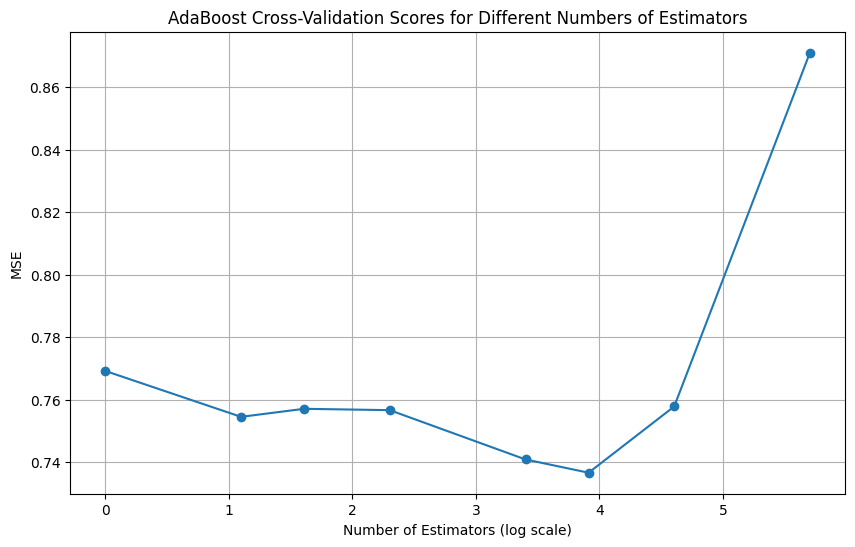

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(np.log(iterations), score_vals_boost, marker='o')
plt.title('AdaBoost Cross-Validation Scores for Different Numbers of Estimators')
plt.xlabel('Number of Estimators (log scale)')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

From this we can decipher that the optimal number of estimators is somewhere between 30 and 50, as the difference in mse between the two is marginal. Thus we choose 40 as our number of estimators for our testing. 

In [81]:
boost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3), n_estimators=40, learning_rate=0.1).fit(X_train, y_train)
y_pred = boost.predict(X_test)
mse_adaboost = mean_squared_error(y_pred, y_test)
print(mse_adaboost)

0.8329968328725837


In [82]:
print("LinearRegression MSE:", mse_lr)
print("Lasso MSE:", mse_lasso)
print("KNN MSE:", mse_knn)
print("RandomForest MSE:", mse_random_forest)
print("Adaboost MSE:", mse_adaboost)
print("Naive MSE (VORP):", mse_naive_vorp)
print("Mean MSE (VORP):", mse_mean_vorp)
print("KNN Feature Importance MSE:", mse_knn_fi)
print("RandomForest with Feature Selection MSE:", mse_random_forest_fs)

LinearRegression MSE: 0.7952451504461084
Lasso MSE: 0.7941494881154297
KNN MSE: 0.8287524042504205
RandomForest MSE: 0.7736432210088056
Adaboost MSE: 0.8329968328725837
Naive MSE (VORP): 0.9443002237021798
Mean MSE (VORP): 1.3937720001994305
KNN Feature Importance MSE: 0.8026505956104576
RandomForest with Feature Selection MSE: 0.7822598276402383


Here we see that our best models is Random Forest (with or without feature selection as the difference between the two is marginal). We also notice that KNN and Adaboost perform the worst, and that KNN with feature importance weighting performs similarly to simple linear regression and lasso regression. 

## Player Projections

In [70]:
# Player Projections based on Random Forest with Feature Selection Model
prediction_df = sorted_df[sorted_df['season'] == 2023].drop('next_year_vorp', axis=1).dropna()
X_2023 = prediction_df.drop(['player_name', 'season'], axis = 1)[feat_names]

# Making predictions
y_pred_2023 = forest.predict(X_2023)
performance_2023 = pd.DataFrame({'Player Name': prediction_df['player_name'], 'Predicted VORP': y_pred_2023})

In [71]:
performance_2023

,Player Name,Predicted VORP
0,A.J. Green,0.092789
1,A.J. Lawson,-0.006451
7,AJ Griffin,0.506000
2,Aaron Gordon,1.499795
3,Aaron Holiday,0.102476
...,...,...
534,Zach Collins,0.763167
535,Zach LaVine,2.194340
536,Zeke Nnaji,-0.004567
537,Ziaire Williams,-0.087843


<a id="part5"></a>

## Conclusion

[Return to contents](#contents)

In conclusion, our random forest model with feature selection and the normal random forest model performed comparably. It outperformed our baseline model by around 15%. VORP is a widely touted basketball statistic that is highly stable year-to-year, so being able to outperform this baseline model (previous year’s VORP) is no small accomplishment. However, we believe that there are areas we could improve the model still. First off, we only used one year previous to predict the following season. We can expand our temporal reach by perhaps using time series analysis. Furthermore, we could add more descriptive statistics in our dataset, as there are many advanced statistics in basketball that provide more information than the simple box score. However, we liked the appeal of only using statistics that were readily available on basketball-reference. 